# Cluster level integration (matching up clusters with correlation)

In [82]:
from __init__ import *
import seaborn as sns 
from scipy.stats import zscore
import matplotlib.pyplot as plt
from natsort import natsorted
import functools

import snmcseq_utils
import CEMBA_update_mysql

In [2]:
log = snmcseq_utils.create_logger()
logging.info('*')

04/10/2018 02:43:28 PM *


# references (gene_annotation)

In [3]:
df_genes = pd.read_table(
    os.path.join(PATH_REFERENCES, 'Annotation', 'gencode.vM16.annotation_genes.tsv'), index_col='gene_id')
df_genes.head()

,gene_name,chr,start,end,strand,gene_type
gene_id,,,,,,
ENSMUSG00000102693.1,4933401J01Rik,chr1,3073253,3074322,+,TEC
ENSMUSG00000064842.1,Gm26206,chr1,3102016,3102125,+,snRNA
ENSMUSG00000051951.5,Xkr4,chr1,3205901,3671498,-,protein_coding
ENSMUSG00000102851.1,Gm18956,chr1,3252757,3253236,+,processed_pseudogene
ENSMUSG00000103377.1,Gm37180,chr1,3365731,3368549,-,TEC


In [42]:
df_genes_v2 = df_genes.reset_index().groupby('gene_name').first()
print(df_genes_v2.shape)
df_genes_v2.head()

(53278, 6)


,gene_id,chr,start,end,strand,gene_type
gene_name,,,,,,
0610005C13Rik,ENSMUSG00000109644.1,chr7,45567794,45575327,-,antisense_RNA
0610006L08Rik,ENSMUSG00000108652.1,chr7,74818818,74853813,-,lincRNA
0610009B22Rik,ENSMUSG00000007777.9,chr11,51685386,51688874,-,protein_coding
0610009E02Rik,ENSMUSG00000086714.1,chr2,26445696,26459390,+,processed_transcript
0610009L18Rik,ENSMUSG00000043644.4,chr11,120348678,120351190,+,bidirectional_promoter_lncRNA


In [4]:
def get_mcc(df, base_call_cutoff=100, sufficient_coverage_fraction=1):
    """Get mcc matrix from mc_c matrix (filtering out low coverage gene or bins)
    """
    logging.info('Getting mcc matrix from mc and c') 
    logging.info('base_call_cutoff={}, sufficient_coverage_fraction={}'.format(
                base_call_cutoff, sufficient_coverage_fraction))
    
    df_c = df.filter(regex="_c$")
    df_c.columns = [col[:-len('_c')] for col in df_c.columns] 
    df_mc = df.filter(regex="_mc$")
    df_mc.columns = [col[:-len('_mc')] for col in df_mc.columns] 
    # a gene is sufficiently covered in % of cells 
    condition = (df_c > base_call_cutoff).sum(axis=1) >= sufficient_coverage_fraction*(df.shape[1])/2.0 

    logging.info("Matrix size before pruning... "+ str(df.shape))
    logging.info("Matrix size after pruning... "+ str(df.loc[condition].shape))
    
    # get mcc matrix with kept bins and nan values for low coverage sites
    df_c_nan = df_c.copy()
    df_c_nan[df_c < base_call_cutoff] = np.nan
    df_mcc = df_mc.loc[condition]/df_c_nan.loc[condition]
    logging.info(df_mcc.shape)

    # imputation (missing value -> mean value of all cells)
    logging.info('Imputing data... (No effect if sufficient_coverage_fraction=1)')
    means = df_mcc.mean(axis=1)
    fill_value = pd.DataFrame({col: means for col in df_mcc.columns})
    df_mcc.fillna(fill_value, inplace=True)
    
    # add suffix
    df_mcc.columns = df_mcc.columns.values + '_mcc'
    
    return df_mcc

In [43]:
def gene_id_to_name(gene_id, df_genes):
    """df_genes
    """
    try:
        return df_genes.loc[gene_id, 'gene_name']
    except:
        return None

def gene_name_to_id(gene_name, df_genes_v2):
    """df_genes
    """
#     df = df_genes.reset_index().groupby('gene_name').first()
    try:
        return df_genes_v2.loc[gene_name, 'gene_id'] 
    except:
        return None

# ATAC preprocessing
- get df_info_atac (tsne, clustering, annotation)
- get data
- get clusters_atac

In [5]:
# atac tsne, clustering, and cells
with snmcseq_utils.cd('/cndd/Public_Datasets/CEMBA/snATACSeq/MiniBrain_fromRongxin'):
    df_clst_atac = pd.read_table('XW45_cluster.txt', header=None, names=['sample', 'cluster_ID'], index_col='sample')
    df_tsne_atac = pd.read_table('XW45_tsne.txt', header=None, names=['sample', 'tsne_x', 'tsne_y'], index_col='sample')
df_info_atac = pd.merge(df_clst_atac, df_tsne_atac, left_index=True, right_index=True)
cells_atac = df_info_atac.index.values
print(cells_atac.shape)

(8567,)


In [ ]:
# atac data DMR
ens = 'Ens10'
f = '/cndd/fangming/atac_count_help/test_counts_dmr.tsv'
f = '/cndd/fangming/atac_count_help/counts_dmr_allc_merged_mCG_cluster_mCHmCG_lv_npc50_k30_rms_results_collapsed_20dms.tsv'
df_atac_raw = pd.read_table(f)

df_atac_raw = df_atac_raw.set_index('gene')
df_atac_raw.head()

# atac bed
ens = 'Ens10'
f = '/cndd/fangming/atac_count_help/dmr_allc_merged_mCG_cluster_mCHmCG_lv_npc50_k30_rms_results_collapsed_3dms.chr2.tsv.DMR.bed'
f = os.path.join(PATH_ENSEMBLES, ens, 'dmr', 'dmr_allc_merged_mCG_cluster_mCHmCG_lv_npc50_k30_rms_results_collapsed_20dms.tsv.DMR.bed')
df_mcc_bed = pd.read_table(f, header=None, 
                       index_col='name',
                       dtype={'chr': object},
                       names=['chr', 'start', 'end', 'name', 'ndms'])
df_mcc_bed['length'] = df_mcc_bed['end'] - df_mcc_bed['start']
df_mcc_bed.head()

# logtpm
tmp = df_atac_raw.divide(df_mcc_bed['length'], axis=0)
logtpm = np.log10(1 + tmp.divide(tmp.sum(axis=0), axis=1))

# find cells in common
cells_atac = np.intersect1d(logtpm.columns, df_info_atac.index)
logtpm = logtpm[cells_atac]
df_info_atac = df_info_atac.loc[cells_atac, :]
print(cells_atac.shape)

# get gene*cluster matrix 
df_atac = logtpm
clusters_atac = pd.DataFrame() 
for label, df_sub in df_info_atac.groupby('cluster_ID'):
    samples = df_sub.index.values
    clusters_atac[label] = df_atac[samples].mean(axis=1)

logging.info("Output shape: {}".format(clusters_atac.shape))

# reorder by natural sort
clusters_atac = clusters_atac[natsorted(clusters_atac.columns)]
clusters_atac.columns = ['atac_'+col.strip('C') for col in clusters_atac.columns]
clusters_atac.head()

In [7]:
# atac_genebody
f = '/cndd/Public_Datasets/CEMBA/snATACSeq/Datasets/CEMBA_3C_171206/CEMBA_3C_171206_merged.gene10kb.counts.tsv'
df = pd.read_table(f, index_col='gene')

# counts to logtpm
gene_lengths = df_genes.loc[df.index, 'end'] - df_genes.loc[df.index, 'start']
gene_lengths_flanking = gene_lengths + 1e4 

tmp = df.divide(gene_lengths_flanking, axis=0)
tmp = tmp.divide(tmp.sum(axis=0))*1e6
logtpm = np.log10(1 + tmp)

In [8]:
# reconcile cells
cells_common = np.intersect1d(df_info_atac.index, logtpm.columns)
df_info_atac = df_info_atac.loc[cells_common, :]
logtpm = logtpm[cells_common]
print(logtpm.shape)
print(df_info_atac.shape)

(53379, 7972)
(7972, 3)


In [9]:
# clusters_atac (Gene_level)
df_atac = logtpm
clusters_atac = pd.DataFrame() 
for label, df_sub in df_info_atac.groupby('cluster_ID'):
    samples = df_sub.index.values
    clusters_atac[label] = df_atac[samples].mean(axis=1)

logging.info("Output shape: {}".format(clusters_atac.shape))

# reorder by natural sort
clusters_atac = clusters_atac[natsorted(clusters_atac.columns)]
clusters_atac.columns = ['atac_'+col.strip('C') for col in clusters_atac.columns]
print(clusters_atac.shape)
clusters_atac.head()

04/10/2018 02:47:02 PM Output shape: (53379, 19)


(53379, 19)


,atac_1,atac_2,atac_3,atac_4,atac_5,atac_6,atac_7,atac_8,atac_9,atac_10,atac_11,atac_12,atac_13,atac_14,atac_15,atac_16,atac_17,atac_18,atac_19
gene,,,,,,,,,,,,,,,,,,,
ENSMUSG00000102693.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000064842.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008281,0.000000,0.000000,0.000000,0.009540,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000051951.5,1.253281,0.268029,1.028194,0.371914,1.430407,1.192122,0.854233,1.083997,1.161126,0.567848,1.159349,1.269193,1.060265,0.554364,1.179268,0.207811,1.290441,0.681507,1.017947
ENSMUSG00000102851.1,0.000000,0.007834,0.000000,0.023601,0.000000,0.003021,0.012024,0.003422,0.000000,0.000000,0.017533,0.006750,0.009915,0.011805,0.008826,0.000000,0.000000,0.000000,0.016409
ENSMUSG00000103377.1,0.000000,0.000000,0.024286,0.000000,0.039258,0.035739,0.026746,0.054621,0.050232,0.160652,0.192132,0.042280,0.059163,0.019566,0.112243,0.004640,0.069514,0.010777,0.024636


# MC preprocessing

In [10]:
# get mc clusters and annotation
ens = 'Ens10'
database = DATABASE
engine = CEMBA_update_mysql.connect_sql(database) 
tsne_type = 'mCHmCG_ndim2_perp30'
cluster_type = 'mCHmCG_lv_npc50_k30'
sql = """SELECT cell_name, tsne_x_{}, tsne_y_{}, cluster_{}, annotation_{}
        FROM {} 
        JOIN cells ON cells.cell_id = {}.cell_id""".format(tsne_type, tsne_type, cluster_type, cluster_type, 
                                                       ens, ens)

df_info_mc = pd.read_sql(sql, engine, index_col='cell_name')
print(df_info_mc.shape)
df_info_mc.head()

df_clst_annot_mc = df_info_mc[
    ['cluster_'+cluster_type, 'annotation_'+cluster_type]].groupby('cluster_'+cluster_type).first().fillna('Glia/Unlabeled')
print(df_clst_annot_mc.shape)

(5352, 4)
(26, 1)


In [ ]:
# get mc dmr
ens = 'Ens10'

# all dmr info
f = os.path.join(PATH_ENSEMBLES, ens, 'dmr', 
                 'dmr_allc_merged_mCG_cluster_mCHmCG_lv_npc50_k30_rms_results_collapsed.tsv')
df_mcc_raw = pd.read_table(f, 
                       dtype={'#chr': object}).rename(columns={'#chr': 'chr'})
# dmr bed file
f = os.path.join(PATH_ENSEMBLES, ens, 'dmr', 
                 'dmr_allc_merged_mCG_cluster_mCHmCG_lv_npc50_k30_rms_results_collapsed_20dms.tsv.DMR.bed')
# f = ('/cndd/fangming/atac_count_help/dmr_allc_merged_mCG_cluster_mCHmCG_lv_npc50_k30_rms_results_collapsed_3dms.chr2.tsv.DMR.bed')
df_mcc_bed = pd.read_table(f, header=None, 
                       dtype={'chr': object},
                       names=['chr', 'start', 'end', 'name', 'ndms'])

# get dmr info only from dmr bed file
# df_mcc = df_mcc_raw.set_index(['chr', 'start', 'end']).loc[df_mcc_bed.set_index(['chr', 'start', 'end']).index, :]
clusters_mcc = pd.merge(df_mcc_raw, df_mcc_bed, on=['chr', 'start', 'end']).set_index('name')
clusters_mcc = clusters_mcc.filter(regex="^methylation_level_*")
print(clusters_mcc.shape)
clusters_mcc.head()

# rename mcc according to cluster annot
clusters_mcc.columns = ['mc_' + col[len('methylation_level_merged_mCG_cluster_mCHmCG_lv_npc50_k30_'):-len('_{}'.format(ens))] 
 + '_' + df_clst_annot_mc.loc[
     int(col[len('methylation_level_merged_mCG_cluster_mCHmCG_lv_npc50_k30_'):-len('_{}'.format(ens))]), 
            'annotation_'+cluster_type] for col in clusters_mcc.columns]

In [122]:
# mc genebody

clusters_mc_c = snmcseq_utils.get_cluster_mc_c(ens, 'CH', genome_regions='genebody', 
                     cluster_col='cluster_'+cluster_type, database=database)
clusters_mcc = get_mcc(clusters_mc_c, base_call_cutoff=1000, sufficient_coverage_fraction=1)

print(clusters_mcc.shape)
clusters_mcc.head()

04/10/2018 09:22:10 PM Found gene*cell matrix in /cndd/Public_Datasets/CEMBA/snmCSeq/Ensembles/Ens10/gene_level/genebody_mCH_Ens10.tsv.bgz
04/10/2018 09:25:16 PM Output shape: (51772, 52)
04/10/2018 09:25:16 PM Getting mcc matrix from mc and c
04/10/2018 09:25:16 PM base_call_cutoff=1000, sufficient_coverage_fraction=1
04/10/2018 09:25:16 PM Matrix size before pruning... (51772, 52)
04/10/2018 09:25:16 PM Matrix size after pruning... (29330, 52)
04/10/2018 09:25:16 PM (29330, 26)
04/10/2018 09:25:16 PM Imputing data... (No effect if sufficient_coverage_fraction=1)


(29330, 26)


,cluster_1_mcc,cluster_2_mcc,cluster_3_mcc,cluster_4_mcc,cluster_5_mcc,cluster_6_mcc,cluster_7_mcc,cluster_8_mcc,cluster_9_mcc,cluster_10_mcc,...,cluster_17_mcc,cluster_18_mcc,cluster_19_mcc,cluster_20_mcc,cluster_21_mcc,cluster_22_mcc,cluster_23_mcc,cluster_24_mcc,cluster_25_mcc,cluster_26_mcc
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000051951.5,0.013761,0.016505,0.017940,0.014267,0.011451,0.013052,0.014645,0.014163,0.012715,0.029372,...,0.012942,0.018790,0.013953,0.012073,0.007599,0.013786,0.007367,0.013978,0.014282,0.018744
ENSMUSG00000103377.1,0.015110,0.027708,0.020891,0.016352,0.013310,0.013931,0.018120,0.015383,0.011690,0.036102,...,0.010172,0.058044,0.020369,0.013772,0.009883,0.014879,0.008289,0.009768,0.012212,0.025572
ENSMUSG00000089699.1,0.015230,0.015997,0.017819,0.013743,0.011584,0.013527,0.015129,0.013857,0.012876,0.032229,...,0.013328,0.022315,0.014776,0.012590,0.007261,0.014232,0.006640,0.014186,0.014519,0.019670
ENSMUSG00000103161.1,0.010090,0.011220,0.011339,0.008410,0.009044,0.010439,0.010316,0.009531,0.008996,0.016012,...,0.009347,0.009426,0.008258,0.007376,0.008415,0.008192,0.008674,0.010904,0.012920,0.008253
ENSMUSG00000102331.1,0.016623,0.021030,0.023130,0.016281,0.012556,0.014772,0.018853,0.015408,0.011755,0.036507,...,0.012110,0.016139,0.014851,0.011783,0.007261,0.014791,0.007542,0.013404,0.014403,0.025684


In [125]:
# clusters_mcc.columns
clusters_mcc.columns = ['mc_'+col[len('cluster_'):-len('_mcc')] 
                        + '_' + df_clst_annot_mc.loc[int(col[len('cluster_'):-len('_mcc')]), 'annotation_'+cluster_type]
                        for col in clusters_mcc.columns]

# RNA preprocessing

In [71]:
# rna clusters and tsne
with snmcseq_utils.cd('/cndd/fangming/integration'):
    df_tsne = pd.read_table('tsne_rna_test_v2.tsv', index_col='sample')
    df_clst = pd.read_table('clustering_rna_test_v2.tsv', index_col='sample')
    
df_info_rna = pd.merge(df_clst, df_tsne, left_index=True, right_index=True)
cells_rna = df_info_atac.index.values
print(cells_rna.shape)

(7972,)


In [91]:
# rna data
# f = '/cndd/fangming/datasets/zeng_smarter_nuclei_MOp/exon_counts.csv.gz'
# df = pd.read_csv(f)
# df = df.set_index('sample_id').T
# df.index = [gene_name_to_id(gene_name, df_genes_v2) for gene_name in df.index] # move from gene_name to gene_id
# df = df[~pd.isnull(df.index)] # remove not found gene

# # counts to logtpm
# gene_lengths = df_genes.loc[df.index, 'end'] - df_genes.loc[df.index, 'start']

# tmp = df.divide(gene_lengths, axis=0)
# tmp = tmp.divide(tmp.sum(axis=0))*1e6
# logtpm = np.log10(1 + tmp)
# logtpm.to_csv('/cndd/fangming/integration/snRNA_logtpm.tsv', 
#               sep='\t', na_rep='NA', index=True, header=True)


f = '/cndd/fangming/integration/processed/snRNA_logtpm.tsv'
logtpm = pd.read_table(f, index_col='gene_id')
print(logtpm.shape)
logtpm.head()

(32324, 6848)


,SM-GE653_S113_E1-50,SM-GE653_S114_E1-50,SM-GE653_S115_E1-50,SM-GE653_S116_E1-50,SM-GE653_S117_E1-50,SM-GE653_S118_E1-50,SM-GE653_S119_E1-50,SM-GE653_S120_E1-50,SM-GE653_S121_E1-50,SM-GE653_S122_E1-50,...,SM-GE66H_S079_E1-50,SM-GE66H_S080_E1-50,SM-GE66H_S081_E1-50,SM-GE66H_S082_E1-50,SM-GE66H_S083_E1-50,SM-GE66H_S084_E1-50,SM-GE66H_S085_E1-50,SM-GE66H_S086_E1-50,SM-GE66H_S087_E1-50,SM-GE66H_S088_E1-50
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000109644.1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.402730,0.0,0.0,0.0,0.0
ENSMUSG00000108652.1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
ENSMUSG00000007777.9,0.0,0.0,2.759902,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.760289,0.0,0.0,0.0,0.0
ENSMUSG00000086714.1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
ENSMUSG00000043644.4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [92]:
# clusters_rna (Gene_level)
clusters_rna = pd.DataFrame() 
for label, df_sub in df_info_rna.groupby('cluster_ID'):
    samples = df_sub.index.values
    clusters_rna[label] = logtpm[samples].mean(axis=1)

logging.info("Output shape: {}".format(clusters_rna.shape))

# reorder by natural sort
clusters_rna = clusters_rna[natsorted(clusters_rna.columns)]
clusters_rna.columns = ['rna_'+col.strip('clusters_') for col in clusters_rna.columns]
print(clusters_rna.shape)
clusters_rna.head()

04/10/2018 05:24:12 PM Output shape: (32324, 22)


(32324, 22)


,rna_1,rna_2,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10,...,rna_13,rna_14,rna_15,rna_16,rna_17,rna_18,rna_19,rna_20,rna_21,rna_22
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000109644.1,0.015335,0.009915,0.029249,0.031157,0.013537,0.018167,0.013291,0.027796,0.027333,0.008472,...,0.013955,0.033614,0.021038,0.011143,0.005131,0.036207,0.000000,0.158340,0.000000,0.000000
ENSMUSG00000108652.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ENSMUSG00000007777.9,0.839011,0.741704,0.663476,0.994576,1.004411,0.257703,0.885794,0.945902,0.882553,0.491642,...,0.910257,0.971398,0.223102,0.865148,1.045921,0.384344,0.275364,0.412663,0.155215,3.217808
ENSMUSG00000086714.1,0.113436,0.111229,0.169029,0.082902,0.106245,0.118996,0.090593,0.158908,0.068946,0.028789,...,0.084892,0.106012,0.120741,0.172415,0.137787,0.154190,0.021184,0.024893,0.000000,0.000000
ENSMUSG00000043644.4,0.123567,0.100221,0.099858,0.233920,0.245048,0.060342,0.079176,0.206045,0.313536,0.073315,...,0.223721,0.168609,0.123971,0.124273,0.177075,0.209749,0.015703,0.133594,0.000000,0.000000


# Preprocessing (check nan and select common set across datasets)

In [132]:
# check df_info_atac, df_info_rna, df_info_mcc
# clusters_mcc, clusters_atac, clusters_rna
print(df_info_atac.shape)
print(df_info_rna.shape)
print(df_info_mc.shape)

# contain nan? (remove optional)
print(clusters_mcc.shape[0] - clusters_mcc[clusters_mcc.isnull().sum(axis=1)==0].shape[0])
print(clusters_atac.shape[0] - clusters_atac[clusters_atac.isnull().sum(axis=1)==0].shape[0])
print(clusters_rna.shape[0] - clusters_rna[clusters_rna.isnull().sum(axis=1)==0].shape[0])

# check common feature set (remove optional)
common_index = functools.reduce(np.intersect1d, (clusters_mcc.index, clusters_atac.index, clusters_rna.index))
print(common_index.shape)
# select common feature 
clusters_mcc = clusters_mcc.loc[common_index, :]
clusters_atac = clusters_atac.loc[common_index, :]
clusters_rna = clusters_rna.loc[common_index, :]
print(clusters_mcc.shape)
print(clusters_atac.shape)
print(clusters_rna.shape)

(7972, 3)
(6848, 3)
(5352, 4)
0
0
0
(22643,)
(22643, 26)
(22643, 19)
(22643, 22)


# correlate

In [143]:

top_genes_atac = clusters_atac.std(axis=1).sort_values(ascending=False).head(10000).index
top_genes_mcc = clusters_mcc.std(axis=1).sort_values(ascending=False).head(10000).index
top_genes_rna = clusters_rna.std(axis=1).sort_values(ascending=False).head(10000).index

index_top = functools.reduce(np.intersect1d, (top_genes_atac, top_genes_mcc, top_genes_rna)) 

print(len(index_top))


data_atac = clusters_atac.rank(pct=True)
data_mcc = 1 - clusters_mcc.rank(pct=True)
data_rna = clusters_rna.rank(pct=True)

feature_genes = index_top.tolist() 
feature_genes = np.unique(feature_genes)
print(len(feature_genes))

data_atac = data_atac.loc[feature_genes, :]
data_mcc = data_mcc.loc[feature_genes, :]
data_rna = data_rna.loc[feature_genes, :]

nclst_atac = data_atac.shape[1]
nclst_mcc = data_mcc.shape[1]
nclst_rna = data_rna.shape[1]
print(data_atac.shape)
print(data_mcc.shape)
print(data_rna.shape)



1842
1842
(1842, 19)
(1842, 26)
(1842, 22)


In [144]:
corr = np.corrcoef(np.concatenate((data_mcc.values, data_atac.values, data_rna), axis=1).T)
labels = np.concatenate((data_mcc.columns, data_atac.columns, data_rna.columns))
print(corr.shape)
print(labels)

(67, 67)
['mc_1_mL4' 'mc_2_mL2/3' 'mc_3_mL2/3' 'mc_4_mL5-1' 'mc_5_mL6-2'
 'mc_6_mL5-1' 'mc_7_mDL-2' 'mc_8_mDL-2' 'mc_9_mSst-1' 'mc_10_mL5-2'
 'mc_11_mPv' 'mc_12_mL6-2' 'mc_13_mL6-2' 'mc_14_mL6-2' 'mc_15_mVip'
 'mc_16_mL6-1' 'mc_17_mNdnf-2' 'mc_18_Glia/Unlabeled' 'mc_19_mL4'
 'mc_20_mL6-2' 'mc_21_Glia/Unlabeled' 'mc_22_mL6-2' 'mc_23_Glia/Unlabeled'
 'mc_24_mPv' 'mc_25_mSst-1' 'mc_26_mDL-3' 'atac_1' 'atac_2' 'atac_3'
 'atac_4' 'atac_5' 'atac_6' 'atac_7' 'atac_8' 'atac_9' 'atac_10' 'atac_11'
 'atac_12' 'atac_13' 'atac_14' 'atac_15' 'atac_16' 'atac_17' 'atac_18'
 'atac_19' 'rna_1' 'rna_2' 'rna_3' 'rna_4' 'rna_5' 'rna_6' 'rna_7' 'rna_8'
 'rna_9' 'rna_10' 'rna_11' 'rna_12' 'rna_13' 'rna_14' 'rna_15' 'rna_16'
 'rna_17' 'rna_18' 'rna_19' 'rna_20' 'rna_21' 'rna_22']


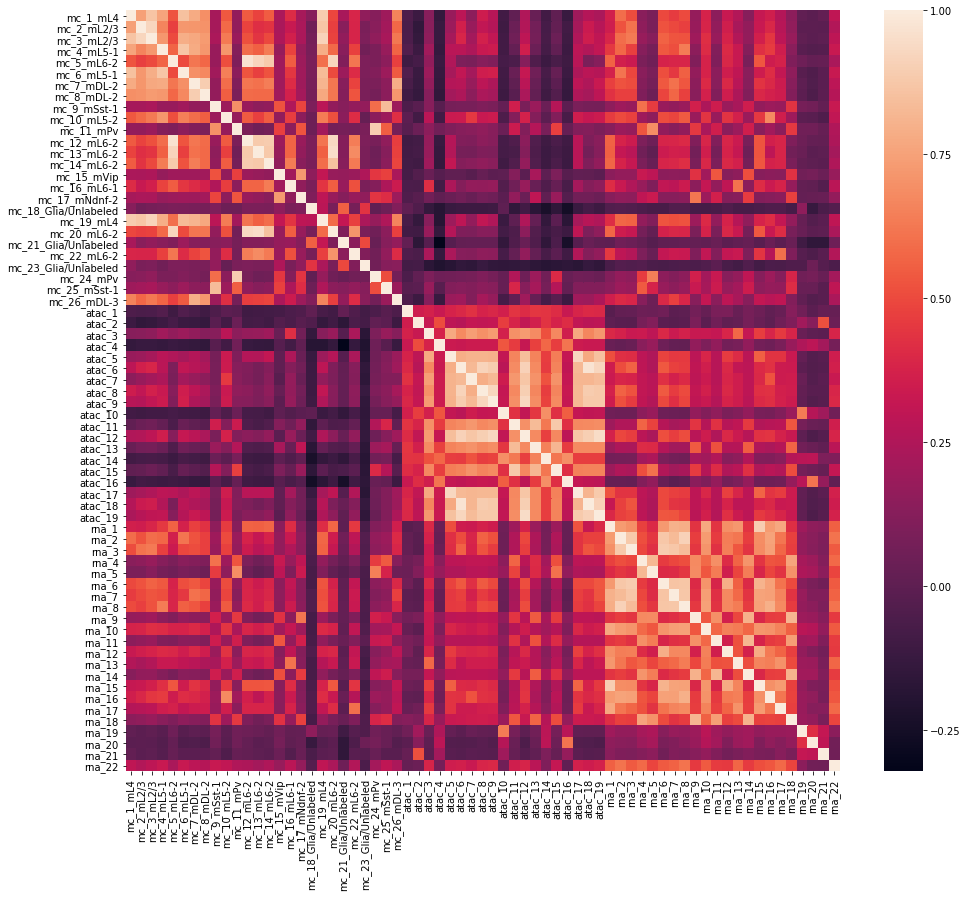

In [146]:
df_corr = pd.DataFrame(corr, index=labels, columns=labels)

fig, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(df_corr, ax=ax)
plt.show()

# re-orange

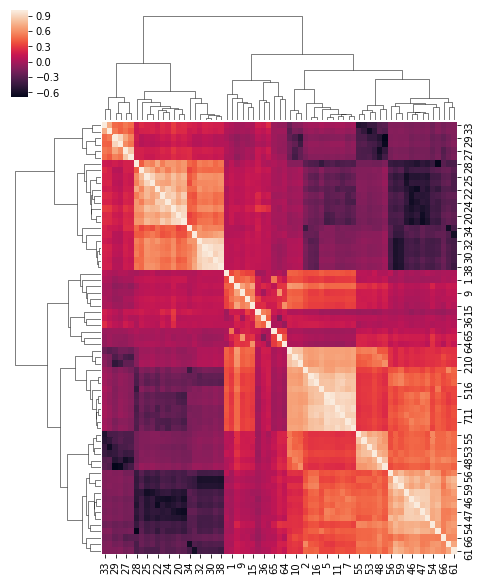

In [110]:
# df_corr = pd.DataFrame(corr[nclst_atac:, :nclst_atac], index=data_mcc.columns, columns=data_atac.columns)
# df_corr = df_corr.T
# reject_threshold = 100 

# df_corr
# df_annot = pd.DataFrame(columns=df_corr.columns, index=df_corr.index)
# for col, idx in df_corr.idxmin().iteritems():
#     if df_corr.loc[idx, col] < reject_threshold:
#         # print(col + ' --> ' + idx)
#         df_annot.loc[idx, col] = '*'
#     else:
#         # print(col + ' cell type not matched!')
#         pass
# df_annot = df_annot.fillna('')

# g = sns.clustermap(df_corr, 
#                    xticklabels=True,
#                    yticklabels=True,
#                   )
# col_orders = [label.get_text() for label in g.ax_heatmap.get_xticklabels()]
# row_orders = [label.get_text() for label in g.ax_heatmap.get_yticklabels()]
# plt.close()
g = sns.clustermap(df_corr, 
#                    cmap='Purples', 
#                    annot=df_annot.reindex(row_orders, col_orders), fmt='',
#                    xticklabels=True,
#                    yticklabels=True,
#                    vmax=-0.3,
                   figsize=(8,10)
                  )
# g.fig.suptitle("snmCSeq clusters v.s. snATACSeq clusters in Mouse primary motor cortex\n"
#          + "(Spearman correlation of {} DMRs)".format(len(feature_genes)))
# g.savefig('/cndd/fangming/integration/correlation_snmcseq_vs_snatacseq_{}DMRs.pdf'.format(len(feature_genes)))
plt.show()

In [ ]:
# reorder row orders?